# Prepare an image generation pipeline

In [1]:
import math

from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt
import numpy as np

from visualization_utils import plot_images_with_titles, plot_image_grid

In [2]:
# pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")

# realisticVisionV51
pipeline = StableDiffusionPipeline.from_pretrained(
    "/home/ryan/invokeai/models/.cache/59348879951894c3810e13e4d088cc2c",
    torch_dtype=torch.float16,
).to("cuda")
pipeline.set_progress_bar_config(disable=True)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
prompt = "a bouquet of flowers"

In [4]:
prompt_embeds, negative_prompt_embeds = pipeline.encode_prompt(
    prompt,
    device="cuda",
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
)

In [5]:
def generate_image(pipeline, prompt_embeds, negative_prompt_embeds, seed=0):
    with torch.no_grad():
        generator = torch.Generator().manual_seed(seed)
        return pipeline(
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            generator=generator,
            num_inference_steps=25,
        ).images[0]


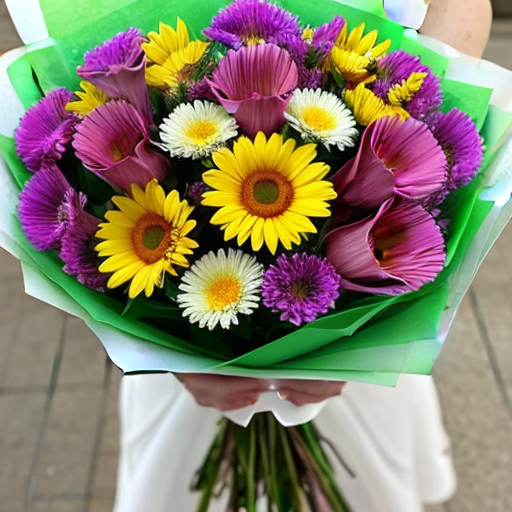

In [6]:
generate_image(pipeline, prompt_embeds, negative_prompt_embeds)

# Experiment with Style Directions

In [7]:
@torch.no_grad()
def build_style_directions(prompt, pipeline, style_prompts):
    base_embeds = pipeline.encode_prompt(
        prompt,
        device="cuda",
        num_images_per_prompt=1,
        do_classifier_free_guidance=True,
    )
    
    style_embeds = []
    for style_prompt in style_prompts:
        merged_prompt = prompt + " " + style_prompt
        style_embeds.append(
            pipeline.encode_prompt(
                merged_prompt,
                device="cuda",
                num_images_per_prompt=1,
                do_classifier_free_guidance=True,
            )
        )
    
    style_directions = []
    for style_embed in style_embeds:
        style_direction = style_embed[0] - base_embeds[0]
        #style_direction = torch.nn.functional.normalize(style_direction, p=2.0, dim=0)
        style_directions.append(style_direction)
    
    style_directions = torch.cat(style_directions)
    return style_directions

@torch.no_grad()
def generate_image_with_style(prompt, pipeline, style_directions, style_weights, style_strength, seed=0):
    prompt_embed, negative_prompt_embed = pipeline.encode_prompt(
        prompt,
        device="cuda",
        num_images_per_prompt=1,
        do_classifier_free_guidance=True,
    )
    style_weights = style_weights.to(device=prompt_embed.device)
    if style_weights.max() > 0.00001:
        # Treat style weights as a relative weighting of the styles (rather than absolute).
        # style_strength controls the overall strength of the style.
        style_weights = torch.nn.functional.normalize(style_weights, p=2.0, dim=0)
        style_weights = style_weights.reshape((style_weights.shape[0], 1, 1))
        prompt_embed = prompt_embed + (style_directions * style_weights).sum(dim=0) * style_strength
    return generate_image(pipeline, prompt_embed, negative_prompt_embed, seed=seed)

To start, we define 5 styles using text prompts. There may be better ways to search for / discover style directions, but prompting is convenient for this test.

In [8]:
style_prompts=[
    ("Cinematic", ". cinematic still, emotional, harmonious, vignette, highly detailed, high budget, bokeh, cinemascope, moody, epic, gorgeous, film grain, grainy"),
    ("Anime", ". anime artwork, anime style, key visual, vibrant, studio anime,  highly detailed"),
    ("Comic", ". graphic illustration, comic book art, graphic novel art, vibrant, highly detailed"),
    ("Cyberpunk", ". neonpunk style, cyberpunk, vaporwave, neon, vibes, vibrant, stunningly beautiful, crisp, detailed, sleek, ultramodern, magenta highlights, dark purple shadows, high contrast, cinematic, ultra detailed, intricate, professional"),
    ("Psychedelic", ". psychedelic style, vibrant colors, swirling patterns, abstract forms, surreal, trippy"),
]

Now, we use the style prompts to calculate style 'directions' for a base prompt.

In [9]:
prompt = "a bouquet of flowers"
style_directions = build_style_directions(
    prompt=prompt,
    pipeline=pipeline,
    style_prompts=[x[1] for x in style_prompts],
)

## Baseline Styles

Here, we visualize the baseline style directions. This is equivalent to simply generating with the respective style prompts.

In [10]:
def show_default_styles_for_prompt(prompt, style_directions, style_prompts):
    images = []
    titles = []
    
    style_strength = 0.0
    style_weights = torch.zeros((len(style_directions),))
    img = generate_image_with_style(prompt, pipeline, style_directions, style_weights, style_strength, seed=0)
    images.append(img)
    titles.append("Original")
    
    style_strength = 1.0
    for idx, style_prompt in enumerate(style_prompts):
        style_weights = torch.zeros((len(style_directions),))
        style_weights[idx] = 1.0
        img = generate_image_with_style(prompt, pipeline, style_directions, style_weights, style_strength, seed=0)
        images.append(img)
        titles.append(style_prompt[0])

    print(f"Prompt: {prompt}")
    plot_images_with_titles(images, titles)


Prompt: a bouquet of flowers


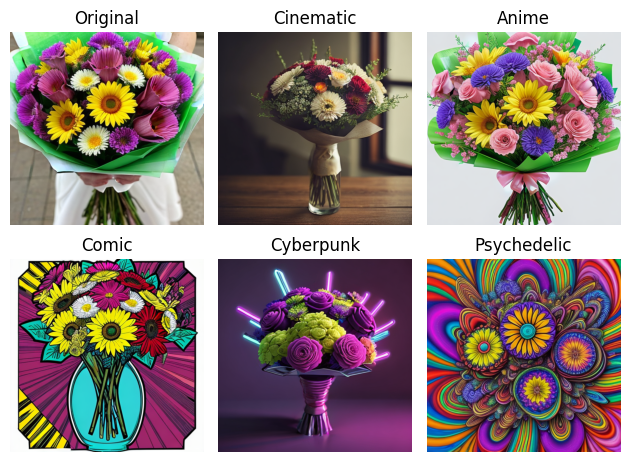

In [11]:
show_default_styles_for_prompt(prompt, style_directions, style_prompts)

## Style Strength

This section examines the effect of style strength. The strength is still being applied to one style direction at a time.

In [12]:
images = []
row_labels = []
col_labels = []

style_strengths = [0.0, 0.6, 0.8, 0.9, 1.0, 1.1]
row_labels = [f"Strength: {s}" for s in style_strengths]
col_labels = [s[0] for s in style_prompts]
for style_strength in style_strengths:
    image_row = []
    for style_idx in range(len(style_prompts)):
        style_weights = torch.zeros((len(style_prompts),))
        style_weights[style_idx] = 1.0
        img = generate_image_with_style(prompt, pipeline, style_directions, style_weights, style_strength, seed=0)
        image_row.append(img)
    images.append(image_row)



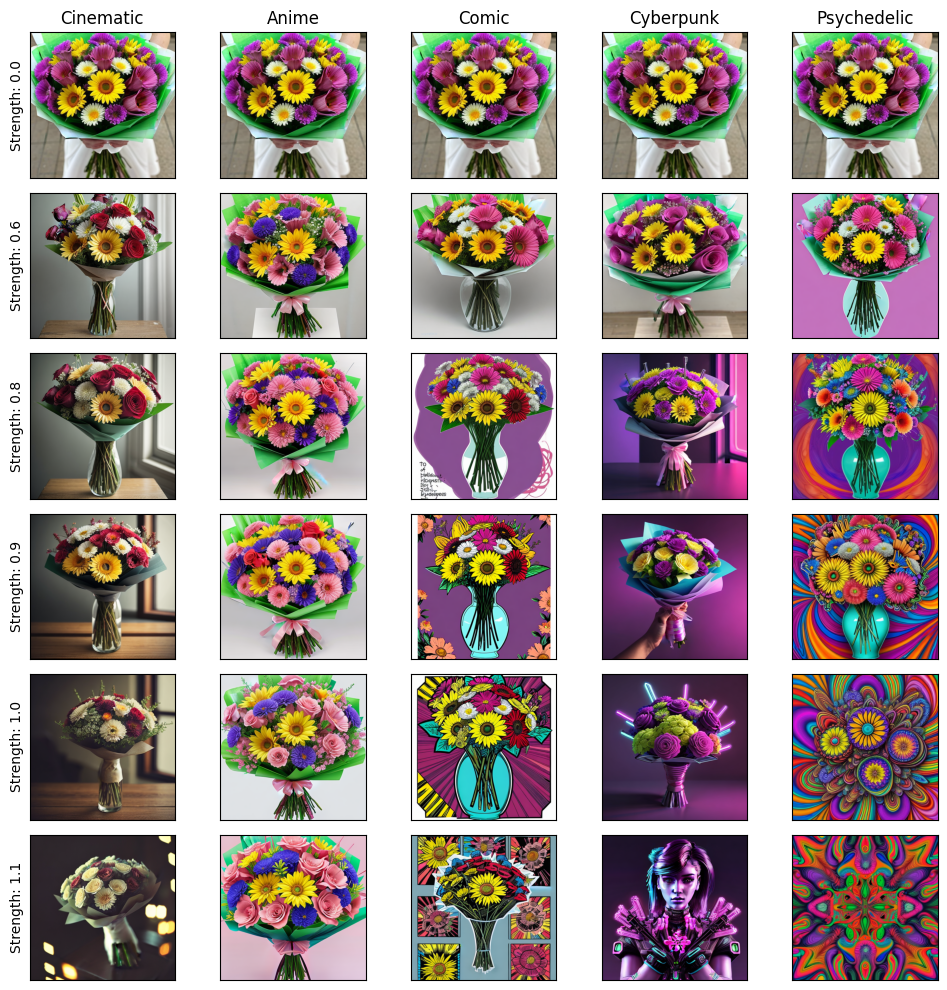

In [13]:
plot_image_grid(images, row_labels, col_labels, figsize=(10, 10))

## Blending Styles

This section explores the effect of blending two style directions together.

In [18]:
def show_blend_between_styles(style_idx_1, style_idx_2, style_prompts):
    style_strength = 1.0
    style_1_weights = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    row_labels = [f"{style_prompts[style_idx_2][0]} -> {style_prompts[style_idx_1][0]}"]
    col_labels = [str(w) for w in style_1_weights]

    image_row = []
    for style_1_weight in style_1_weights:
        style_weights = torch.zeros((len(style_prompts),))
        style_weights[style_idx_1] = style_1_weight
        style_weights[style_idx_2] = 1.0 - style_1_weight
        img = generate_image_with_style(prompt, pipeline, style_directions, style_weights, style_strength, seed=0)
        image_row.append(img)
    images = [image_row]
    plot_image_grid(images, row_labels, col_labels, figsize=(10, 5))
    

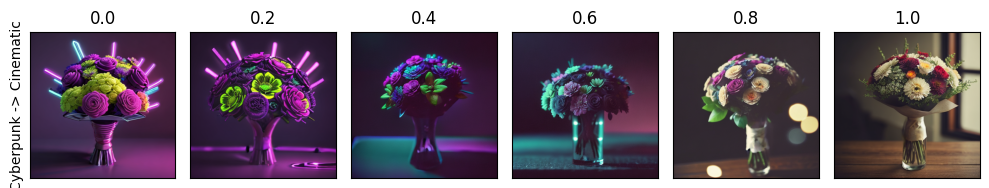

In [15]:
# Cyberpunk -> Cinematic
show_blend_between_styles(0, 3, style_prompts)

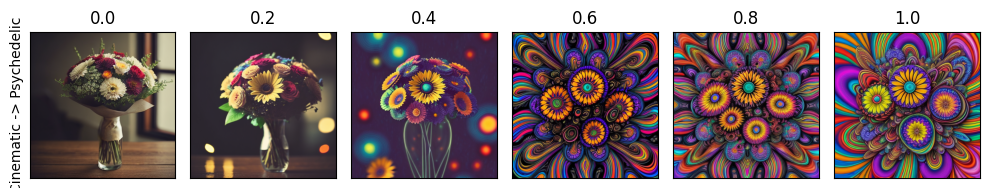

In [16]:
# Cinematic -> Psychedelic
show_blend_between_styles(4, 0, style_prompts)

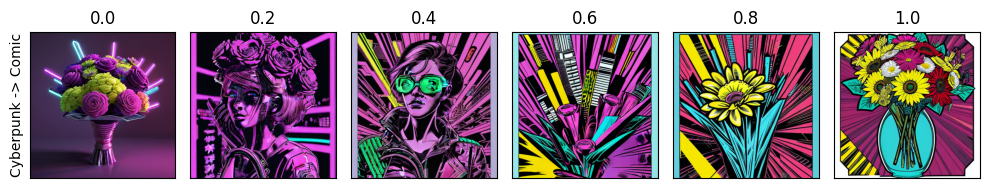

In [17]:
# Cyberpunk -> Comic
show_blend_between_styles(2, 3, style_prompts)

## Compatibility with new prompts
This section explores the effect of applying style directions generated with one prompt to another prompt. (The results are currently very poor.)

In [19]:
def show_styles_on_new_prompts():
    images = []
    row_labels = []
    col_labels = []
    
    style_weight_tensors = [
        torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0]), # No style
        torch.tensor([1.0, 0.0, 0.0, 0.0, 0.0]), # Cinematic
        torch.tensor([0.0, 0.0, 0.0, 1.0, 0.0]), # Cyberpunk
        torch.tensor([1.0, 0.0, 0.0, 1.0, 0.0]), # Cinematic-Cyberpunk
    ]
    col_labels = ["No style", "Cinematic", "Cyberpunk", "Cinematic-Cyberpunk"]
    
    row_labels = ["a field of tulips", "a man wearing glasses", "a futuristic concrete bunker"]
    
    style_strength = 1.0
    for new_prompt in row_labels:
        image_row = []
        for style_weight_tensor in style_weight_tensors:
            img = generate_image_with_style(new_prompt, pipeline, style_directions, style_weight_tensor, style_strength, seed=0)
            image_row.append(img)
        images.append(image_row)
    plot_image_grid(images, row_labels, col_labels, figsize=(10, 10))
    

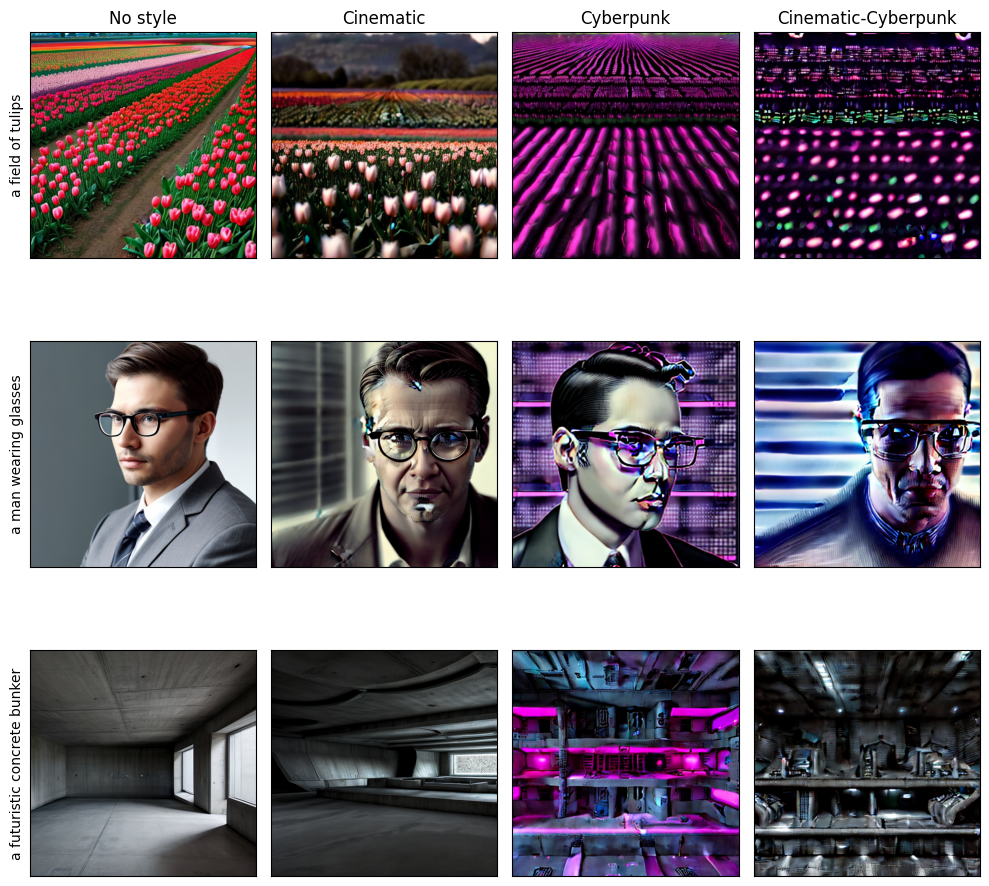

In [20]:
show_styles_on_new_prompts()

## Style Consistency Across Prompts
This section examines the consistency of the styles across different base prompts (when the style directions are re-generated).

Prompt: a field of tulips


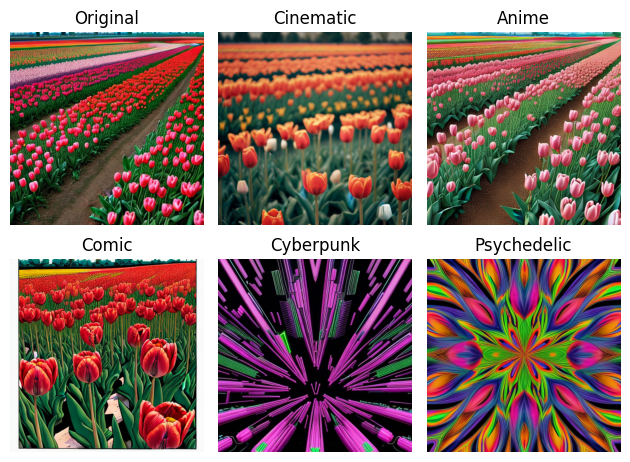

In [21]:
prompt = "a field of tulips"
style_directions = build_style_directions(
    prompt=prompt,
    pipeline=pipeline,
    style_prompts=[x[1] for x in style_prompts],
)
show_default_styles_for_prompt(prompt, style_directions, style_prompts)

Prompt: a man wearing glasses


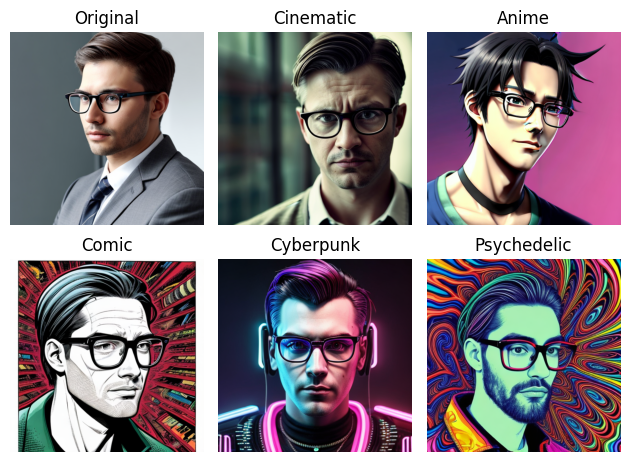

In [22]:
prompt = "a man wearing glasses"
style_directions = build_style_directions(
    prompt=prompt,
    pipeline=pipeline,
    style_prompts=[x[1] for x in style_prompts],
)
show_default_styles_for_prompt(prompt, style_directions, style_prompts)

Prompt: a futuristic concrete bunker


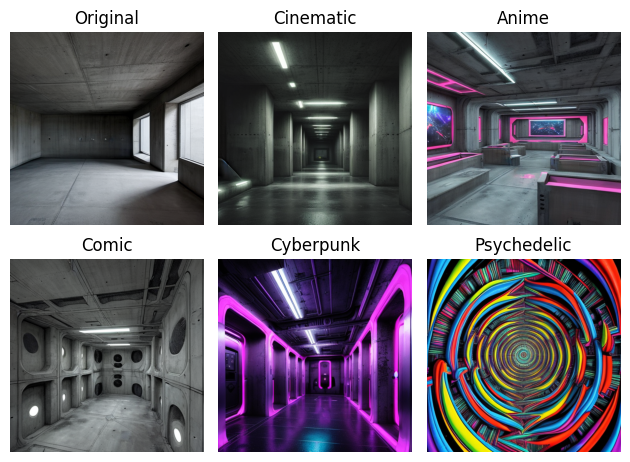

In [23]:
prompt = "a futuristic concrete bunker"
style_directions = build_style_directions(
    prompt=prompt,
    pipeline=pipeline,
    style_prompts=[x[1] for x in style_prompts],
)
show_default_styles_for_prompt(prompt, style_directions, style_prompts)

## Open Questions
- Is there a better way to find style "directions" than manually crafting prompts?
- What is the best way to blend style directions?
    - lerp the embeddings?
    - maybe there is some solution that involves embedding masking?
    - perhaps we need to handle BOS/EOS tokens in a special way?
    - blend in text space rather than embedding space?
- How well do style directions transfer to new prompts?
- How would this feature really be much better than just sharing a good style prompt?
    - It enables blending of style 'directions'. Is this valuable?